# Text Mining para detectar textos sobre desastres en Tweets

### Limpieza y preprocesamiento de texto

In [79]:
import re
import unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from IPython.display import display
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os
import html as ihtml 

#### Patrones reutilizables

In [80]:
URL_RE = re.compile(r'https?://\S+|[www.\S+](http://www.\S+)', flags=re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
HTML_TAG_RE    = re.compile(r'<.*?>')
EMOTICON_RE    = re.compile(
	r'(?:\:\)|:-\)|:\$|:-\(|:D|;\-\)|;\-\(|:-/|:\/|:\'\(|:P|:-P|;P|;-P|:o|:-o|:O|:-O)'
)
EMOJI_RE = re.compile('\[\U00010000-\U0010FFFF]', flags=re.UNICODE)
MULTISPACE_RE = re.compile(r'\s+')


<>:8: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
C:\Users\ncast\AppData\Local\Temp\ipykernel_17804\2624057981.py:8: SyntaxWarning: invalid escape sequence '\['
  EMOJI_RE = re.compile('\[\U00010000-\U0010FFFF]', flags=re.UNICODE)


#### Stopwords de scikit-learn y preservación de negaciones

In [81]:
_stopwords = set(ENGLISH_STOP_WORDS)
_neg_keep = {"not", "no", "nor", "never"}
_stopwords = _stopwords.difference(_neg_keep)

def _normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def _expand_contractions(text: str) -> str:
    text = re.sub(r"\bwon't\b", "will not", text, flags=re.IGNORECASE)
    text = re.sub(r"\bcan't\b", "can not", text, flags=re.IGNORECASE)
    text = re.sub(r"n['’]t\b", " not", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]re\b", " are", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]s\b", " is", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]d\b", " would", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]ll\b", " will", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]ve\b", " have", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]m\b", " am", text, flags=re.IGNORECASE)
    return text

def _collapse_elongations(text: str) -> str:
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [82]:
def clean_text(
    text,
    lowercase: bool = True,
    remove_urls: bool = True,
    remove_mentions: bool = True,
    strip_hashtag_sign: bool = True,
    remove_emoticons: bool = True,
    remove_emojis: bool = True,
    remove_punctuation: bool = True,
    remove_numbers: bool = True,
    keep_911: bool = True,
    remove_stopwords: bool = True,
    keep_negations: bool = True,
    collapse_repeated_chars: bool = True,
    decode_html_entities=True,          
    drop_tokens=None, 
):
    
    """
    Retorna un string limpio listo para vectorizar.

    Parámetros clave:
    - remove_numbers: elimina números (útil para ruido)
    - keep_911: si True, preserva el token '911' aunque remove_numbers=True
    - remove_stopwords: quita artículos/preposiciones/conjunciones
    - keep_negations: conserva 'no', 'not', 'never', 'nor'
    """

    if text is None:
        return ""
    text = _normalize_unicode(str(text))
    if decode_html_entities:
        text = ihtml.unescape(text)     
    if lowercase:
        text = text.lower()

    text = _expand_contractions(text)
    if remove_urls:      text = URL_RE.sub(" ", text)
    if remove_mentions:  text = MENTION_RE.sub(" ", text)
    if strip_hashtag_sign:
        text = HASHTAG_RE.sub(r"\1", text)

    text = HTML_TAG_RE.sub(" ", text)
    if remove_emoticons: text = EMOTICON_RE.sub(" ", text)
    if remove_emojis:    text = EMOJI_RE.sub(" ", text)

    if remove_numbers and keep_911:
        text = re.sub(r"\b911\b", "__PRESERVE_911__", text)
    if remove_punctuation:
        text = re.sub(r"[^a-zA-Z\s]", " ", text)
    if remove_numbers and keep_911:
        text = text.replace("__PRESERVE_911__", "911")

    if collapse_repeated_chars:
        text = _collapse_elongations(text)

    tokens = text.split()
    sw = set()
    if remove_stopwords:
        sw = set(_stopwords)
        if keep_negations:
            sw = sw.difference(_neg_keep)
    if drop_tokens:
        sw |= set(drop_tokens)          
    tokens = [t for t in tokens if t not in sw]

    text = " ".join(tokens)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

<small>

### Justificación de Preprocesamiento 

Primero, normalizamos a minúsculas y a Unicode NFKC para corregir artefactos (mojibake) y homogeneizar el texto. Luego expandimos contracciones (e.g., can’t → can not) para conservar las negaciones, que son informativas en descripciones de eventos. Eliminamos URLs, menciones y etiquetas HTML, y de los hashtags retiramos solo el # para conservar la palabra clave (p. ej., #flood → flood). Quitamos emoticonos/emojis (señales visuales poco útiles para detectar desastres reales), puntuación y números para reducir ruido, con una excepción configurable para “911” por su relevancia potencial. Colapsamos alargamientos (e.g., goooooal → goaal) para evitar que variantes ortográficas inflen el vocabulario. Finalmente, aplicamos stopwords en inglés pero preservando negaciones (no, not, never, nor), de modo que el modelo no pierda la señal de ausencia o contraindicación (p. ej., “no fire reported”).Estas decisiones favorecen un vocabulario compacto y centrado en términos clave de incidentes (flood, fire, evacuation, warning, crash), lo que suele mejorar la precisión de un clasificador lineal con n-gramas. 

</small>

#### Uso sobre el dataframe `df`

In [83]:
df = pd.read_csv("train.csv")

df["clean_text"] = df["text"].apply(
    lambda t: clean_text(
    t,
    remove_numbers=True,
    keep_911=True,
    remove_stopwords=True,
    keep_negations=True,
    )
)

# (opcional) Tokens como lista:
df["tokens"] = df["clean_text"].str.split()
df[["id", "text", "clean_text", "target"]].head()

,id,text,clean_text,target
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,1
1,4,Forest fire near La Ronge Sask. Canada,forest near la ronge sask canada,1
2,5,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,1
3,6,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,1
4,7,Just got sent this photo from Ruby #Alaska as ...,just got sent photo ruby alaska smoke wildfire...,1


#### Frecuencia de palabras (desastre vs. no) y n-gramas

In [84]:
def get_top_ngrams(texts, ngram_range=(1,1), top_n=25, min_df=1):
    """
    Retorna un DataFrame con las frecuencias de n-gramas más comunes en 'texts'.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    vocab = np.array(vectorizer.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1]
    top_idx = order[:top_n]
    
    return pd.DataFrame({
        "ngram": vocab[top_idx],
        "freq": freqs[top_idx]
    })

In [85]:
def plot_top_bars(df_freq, title, top_n=15):
    """
    Grafica barras para los top_n n-gramas de un DataFrame con columnas ['ngram','freq'].
    Reglas: matplotlib, una sola figura, sin estilo ni colores específicos.
    """
    
    top = df_freq.head(top_n).iloc[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(top['ngram'], top['freq'])
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('Término')
    plt.tight_layout()
    plt.show()

In [86]:
def chi2_informative_terms(texts, y, ngram_range=(1,1), top_k=25, min_df=2):
    """
    Devuelve dos DataFrames con los términos más asociados a cada clase según chi-cuadrado.
    - top_disaster: términos fuertemente asociados a target=1
    - top_nondisaster: términos fuertemente asociados a target=0
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    chi2_vals, p = chi2(X, y)

    # Orden global
    order = np.argsort(chi2_vals)[::-1]

    # Para separarlos por clase, calculamos la media de X en cada clase
    X1_mean = X[y == 1].mean(axis=0).A1 + 1e-9
    X0_mean = X[y == 0].mean(axis=0).A1 + 1e-9
    log_ratio = np.log(X1_mean / X0_mean)

    # Términos pro-clase 1: alto chi2 y log_ratio positivo
    mask1 = log_ratio > 0
    order1 = np.argsort(chi2_vals * mask1)[::-1]
    top1 = [i for i in order1 if mask1[i]][:top_k]

    # Términos pro-clase 0: alto chi2 y log_ratio negativo
    mask0 = log_ratio < 0
    order0 = np.argsort(chi2_vals * mask0)[::-1]
    top0 = [i for i in order0 if mask0[i]][:top_k]
    top_disaster = pd.DataFrame({"term": feature_names[top1], "chi2": chi2_vals[top1], "log_ratio": log_ratio[top1]})
    top_nondisaster = pd.DataFrame({"term": feature_names[top0], "chi2": chi2_vals[top0], "log_ratio": log_ratio[top0]})
    
    return top_disaster, top_nondisaster

#### Unigramas por clase (frecuencia)

In [87]:
texts_1 = df.loc[df["target"] == 1, "clean_text"].fillna("")
texts_0 = df.loc[df["target"] == 0, "clean_text"].fillna("")

In [88]:
top_uni_1 = get_top_ngrams(texts_1, ngram_range=(1,1), top_n=25, min_df=1)
top_uni_0 = get_top_ngrams(texts_0, ngram_range=(1,1), top_n=25, min_df=1)

In [89]:
display("Top unigramas - Desastres (target=1)", top_uni_1)

'Top unigramas - Desastres (target=1)'

,ngram,freq
0,not,214
1,news,146
2,disaster,121
3,california,115
4,no,115
5,suicide,112
6,police,109
7,people,105
8,killed,95
9,hiroshima,94


In [90]:
display("Top unigramas - No desastres (target=0)", top_uni_0)

'Top unigramas - No desastres (target=0)'

,ngram,freq
0,not,531
1,like,254
2,just,234
3,new,171
4,no,151
5,body,116
6,video,96
7,people,94
8,love,91
9,day,86


#### Gráficas

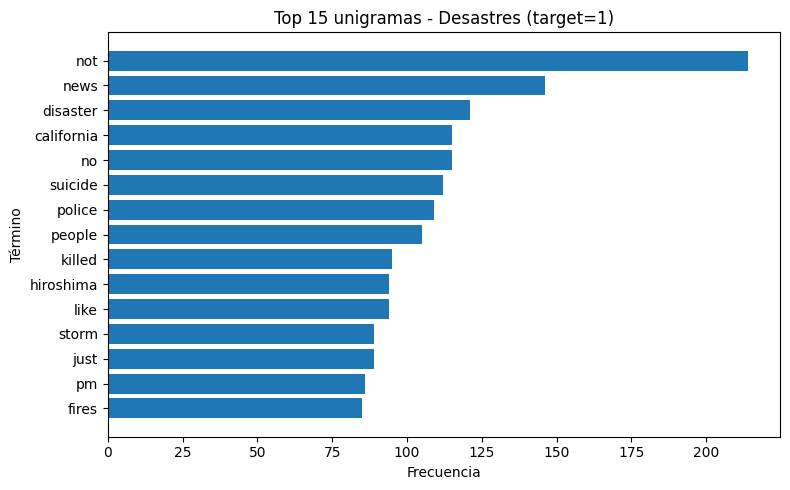

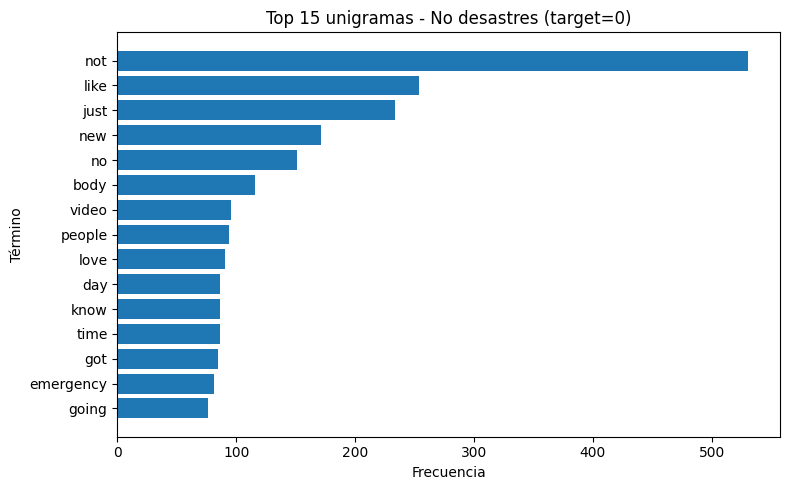

In [91]:
plot_top_bars(top_uni_1, "Top 15 unigramas - Desastres (target=1)", top_n=15)
plot_top_bars(top_uni_0, "Top 15 unigramas - No desastres (target=0)", top_n=15)

<small>

### Análisis de Unigramas 
En los unigramas de desastres (1) predominan términos claramente ligados a eventos reales (disaster, storm, fires, crash, train, emergency, bomb, nuclear, attack, wildfire), junto con lugares o referentes específicos (california, hiroshima, mh) y vocabulario noticioso/institucional (news, police, families), lo que respalda la naturaleza informativa de estos tuits. En no desastres (0) destacan palabras conversacionales y genéricas (like, just, new, love, day, know, time, want, good, think, man, world), además de marcadores de plataforma como rt o expresiones coloquiales (lol). Llama la atención que not y no sean frecuentes en ambas clases: es consistente con haber preservado negaciones (útiles para el contexto: “not a drill”, “no injuries”) aunque no son términos de dominio; conviene mantenerlas para el modelo pero relativizar su peso en las visualizaciones. También aparece emergency en ambas listas, lo que sugiere polisemia (state of emergency vs. emergency room, etc.); por ello, el análisis con bigramas/trigramas resulta clave para desambiguar contexto y mejorar la discriminación.

<small>

#### Bigramas y trigramas por clase (frecuencia)

In [92]:
top_bi_1 = get_top_ngrams(texts_1, ngram_range=(2,2), top_n=25, min_df=1)
top_bi_0 = get_top_ngrams(texts_0, ngram_range=(2,2), top_n=25, min_df=1)
top_tri_1 = get_top_ngrams(texts_1, ngram_range=(3,3), top_n=25, min_df=1)
top_tri_0 = get_top_ngrams(texts_0, ngram_range=(3,3), top_n=25, min_df=1)

In [93]:
display("Top bigramas - Desastres (target=1)", top_bi_1)

'Top bigramas - Desastres (target=1)'

,ngram,freq
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,37
4,suicide bombing,35
5,california wildfire,34
6,bomber detonated,30
7,yr old,29
8,confirmed mh,29
9,homes razed,29


In [94]:
display("Top bigramas - No desastres (target=0)", top_bi_0)

'Top bigramas - No desastres (target=0)'

,ngram,freq
0,cross body,39
1,liked video,34
2,body bag,27
3,body bagging,24
4,burning buildings,23
5,body bags,22
6,reddit quarantine,21
7,looks like,21
8,did not,21
9,quarantine offensive,21


In [95]:
display("Top trigramas - Desastres (target=1)", top_tri_1)

'Top trigramas - Desastres (target=1)'

,ngram,freq
0,suicide bomber detonated,30
1,northern california wildfire,29
2,pkk suicide bomber,28
3,homes razed northern,28
4,latest homes razed,28
5,bomber detonated bomb,28
6,old pkk suicide,27
7,razed northern california,27
8,yr old pkk,27
9,families affected fatal,26


In [96]:
display("Top trigramas - No desastres (target=0)", top_tri_0)

'Top trigramas - No desastres (target=0)'

,ngram,freq
0,reddit quarantine offensive,21
1,quarantine offensive content,20
2,cross body bag,19
3,pick fan army,17
4,reddit new content,16
5,new content policy,16
6,china stock market,16
7,stock market crash,16
8,ignition knock detonation,15
9,goes effect horrible,15


<small>

### Análisis de Bigramas y Trigramas 

En desastres (1) los bigramas y trigramas refuerzan contexto inequívoco de incidentes: suicide bomber / suicide bombing / bomber detonated, oil spill, severe thunderstorm, california wildfire / northern california wildfire, families affected / fatal outbreak, obama declares disaster, typhoon devastated saipan o wreckage conclusively confirmed (MH / Malaysia). Estas combinaciones muestran tipo de evento, lugar y acción, lo que ayuda al modelo a diferenciar “crash” aéreo/terrestre de otros usos, y a subir precisión frente a unigramas sueltos.

En no desastres (0) aparecen patrones claramente no catastróficos: compras (cross body bag), plataforma/moderación (reddit quarantine offensive / content policy), conversación cotidiana (looks/feel like, did/does not, not know), y finanzas (stock market crash, china stock market). También surgen frases acústicas ambiguas (heard loud bang/nearby), que sin contexto podrían inducir falsos positivos; los n-gramas resuelven esta ambigüedad al anclar “crash” a “market” o “body” a “bag”. En síntesis, usar ngram_range=(1,2) o (1,3) capta relaciones léxicas clave (evento-acción-lugar) y reduce ruido semántico, mejorando la precisión del clasificador.

</small>

### Palabras más informativas (chi-cuadrado)

#### Identificamos términos con mayor asociación estadística a cada clase.

<small>

- `log_ratio > 0` → aparece relativamente más en `target=1` (desastre).
- `log_ratio < 0` → aparece relativamente más en `target=0` (no desastre).

</small>


In [97]:
y = df["target"].astype(int).values
top_disaster, top_nondisaster = chi2_informative_terms(df["clean_text"].fillna(""), y, ngram_range=(1,1), top_k=25, min_df=1)

In [98]:
display("Términos más informativos para Desastres (chi², unigramas)", top_disaster)

'Términos más informativos para Desastres (chi², unigramas)'

,term,chi2,log_ratio
0,california,133.903197,3.236411
1,suicide,127.059709,3.055827
2,hiroshima,121.493276,4.826530
3,killed,113.454993,3.450821
4,mh,93.629588,4.573694
5,families,86.501530,2.731778
6,wildfire,85.167230,3.824197
7,northern,84.955060,16.789298
8,legionnaires,80.972791,16.741289
9,bombing,80.799762,3.404133


In [99]:
display("Términos más informativos para No-Desastres (chi², unigramas)", top_nondisaster)

'Términos más informativos para No-Desastres (chi², unigramas)'

,term,chi2,log_ratio
0,not,61.657727,-0.625547
1,body,53.096230,-1.762300
2,love,43.108062,-1.829725
3,like,36.148154,-0.710800
4,just,31.307654,-0.683445
5,new,31.009681,-0.833073
6,bags,29.733003,-3.477958
7,let,27.594041,-1.408437
8,bag,27.479770,-3.405637
9,lol,26.582510,-1.646670


<small>

### Uso de chi-cuadrado 

Con chi-cuadrado y el log_ratio observamos que los términos más asociados a la clase de desastres (1) no solo nombran el evento, sino también lugar y gravedad: california, hiroshima, japan, malaysia (geografía); wildfire, typhoon, severe, debris, bomb(ing), bomber, nuclear, train (tipo/impacto) y families, police, news (marco informativo). Destaca que varios tienen log_ratio muy alto (northern, legionnaires, severe, debris, migrants), es decir, aparecen casi exclusivamente en la clase 1 y son excelentes señales para el modelo; otros como disaster, news, police tienen asociación positiva pero menor (más genéricos). En conjunto, estos unigramas confirman el carácter reportativo de los tuits de desastres y justifican usar n-gramas para capturar “evento + lugar/acción” (p. ej., northern california wildfire).

Para no desastres (0), los términos informativos reflejan lenguaje conversacional o de plataforma/consumo: like, just, love, new, want, better, song, reddit, content, ebay y objetos como bag/bags (que en bigramas aparecen como cross body bag). Llama la atención que palabras potencialmente “alarmistas” (panic/panicking, blew, explode, wrecked, harm) tengan log_ratio negativo: en el corpus suelen usarse figurativamente (deporte, opiniones, humor), por lo que su presencia aislada no implica desastre; aquí los bigrama/trigrama ayudan a desambiguar (stock market crash vs. train crash, body bag vs. cross body bag). 

</small>

## Análisis Exploratorio de los Datos

In [100]:
texts_1 = df.loc[df["target"] == 1, "clean_text"].fillna("")
texts_0 = df.loc[df["target"] == 0, "clean_text"].fillna("")

### Palabras más repetidas por categorías y frecuencias 

In [101]:
def term_freq_df(texts, ngram_range=(1,1), min_df=1):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(texts)
    vocab = np.array(vec.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    out = pd.DataFrame({"term": vocab, "freq": freqs}).sort_values("freq", ascending=False).reset_index(drop=True)
    return out

freq_1 = term_freq_df(texts_1, (1,1))
freq_0 = term_freq_df(texts_0, (1,1))

display(freq_1.head(20))
display(freq_0.head(20))

most_1 = freq_1.iloc[0]
most_0 = freq_0.iloc[0]

print(f"Más repetida en DESASTRES (1): {most_1.term!r} (freq={int(most_1.freq)})")
print(f"Más repetida en NO DESASTRES (0): {most_0.term!r} (freq={int(most_0.freq)})")

,term,freq
0,not,214
1,news,146
2,disaster,121
3,no,115
4,california,115
5,suicide,112
6,police,109
7,people,105
8,killed,95
9,like,94


,term,freq
0,not,531
1,like,254
2,just,234
3,new,171
4,no,151
5,body,116
6,video,96
7,people,94
8,love,91
9,time,86


Más repetida en DESASTRES (1): 'not' (freq=214)
Más repetida en NO DESASTRES (0): 'not' (freq=531)


<small>

### Palabra más repetida  

Aquí, la palabra más repetida en ambas categorías es “not” (desastres=214; no-desastres=531), seguida en desastres por vocabulario informativo y de incidente (news=146, disaster=121, california=115, suicide=112, police=109, killed=95, storm/fires/crash≈85–89). En no-desastres dominan marcadores conversacionales (like=254, just=234, new=171, no=151, body=116, video=96, love/time/know/day≈86). La presencia alta de negaciones (“not”, “no”) es coherente con la decisión de preservarlas porque aportan contexto (“not a drill”, “no injuries”), aunque sesgan el ranking de frecuencias al ocupar los primeros lugares.

Respecto a términos compartidos (people y emergency aparecen en ambas listas), su polisemia exige contexto: emergency puede referir a state of emergency (desastre) o a emergency room/uso coloquial (no-desastre). Por ello, indicamos que mantuvimos negaciones para el modelo, pero para interpretar tendencias optamos por enfatizar términos de dominio (p. ej., disaster, wildfire, crash, police, killed) y apoyarnos en n-gramas que desambiguan usos figurativos (market crash vs. train crash). Además, detectamos posibles artefactos como pm (hora) que conviene filtrar en visualizaciones sin afectar el entrenamiento.

</small>

### Nube de palabras por categoría 

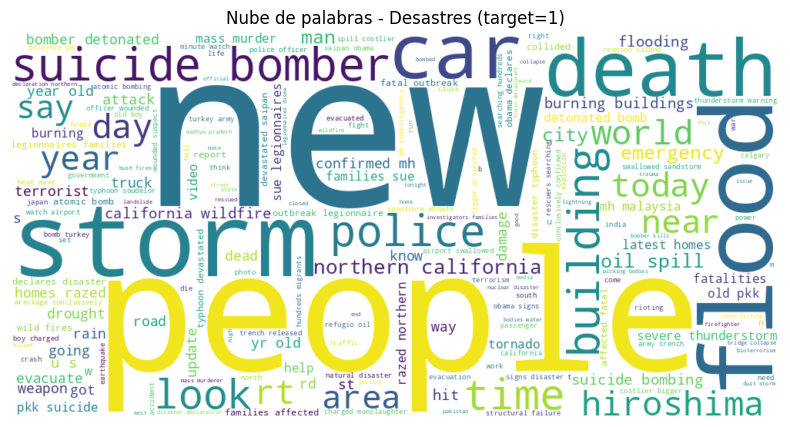

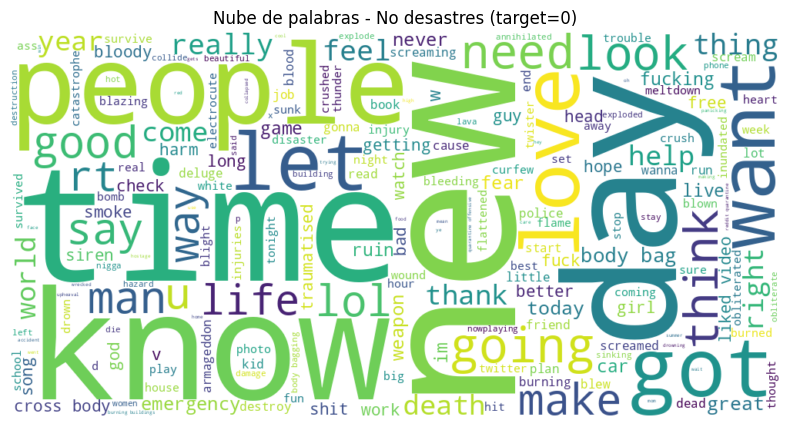

In [102]:
os.makedirs("outputs", exist_ok=True)

def plot_wordcloud(texts, title, savepath=None):
    wc = WordCloud(width=1000, height=500, background_color="white").generate(" ".join(texts))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

plot_wordcloud(texts_1, "Nube de palabras - Desastres (target=1)", "outputs/wc_target1.png")
plot_wordcloud(texts_0, "Nube de palabras - No desastres (target=0)", "outputs/wc_target0.png")

<small>

### Análisis de Nubes de Palabras

En la nube de desastres (1) sobresalen términos de evento e impacto como flood, storm, wildfire, suicide, bomber, death, crash, building(s), police, emergency, junto con lugares/referentes (california, hiroshima) y marcas de noticia (new, today). El tamaño de people y new refuerza el tono reportativo (muchos tuits informan a terceros sobre lo ocurrido), mientras que combinaciones visibles como california/northern/wildfire apuntan a descripciones situadas del incidente.

En no desastres (0) dominan palabras conversacionales y de vida diaria: time, know, new, day, love, look, going, got, need, think, want, lol. Esto sugiere mensajes personales, recomendaciones o comentarios casuales, muy distintos del léxico de emergencia. Notamos que términos ambiguos como emergency o death pueden aparecer en ambos contextos; por eso, más allá de la nube, conviene apoyarse en n-gramas (p. ej., state of emergency vs. emergency room) para fijar el contexto y mejorar la discriminación del modelo.

</small>

### Histogramas 

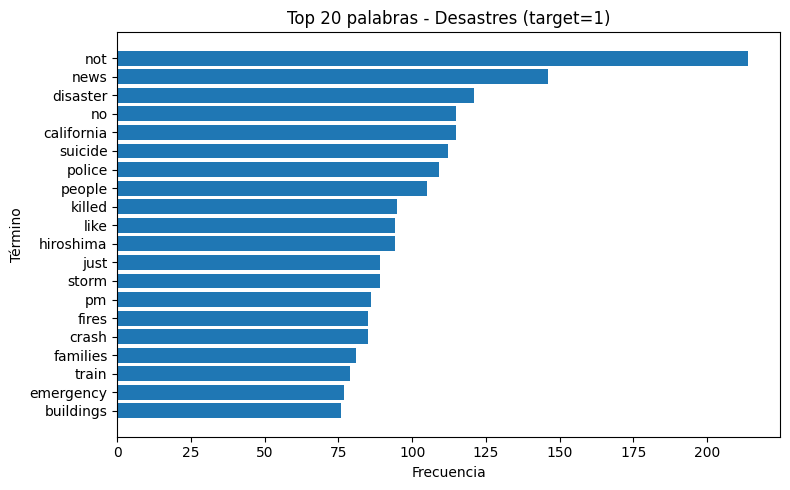

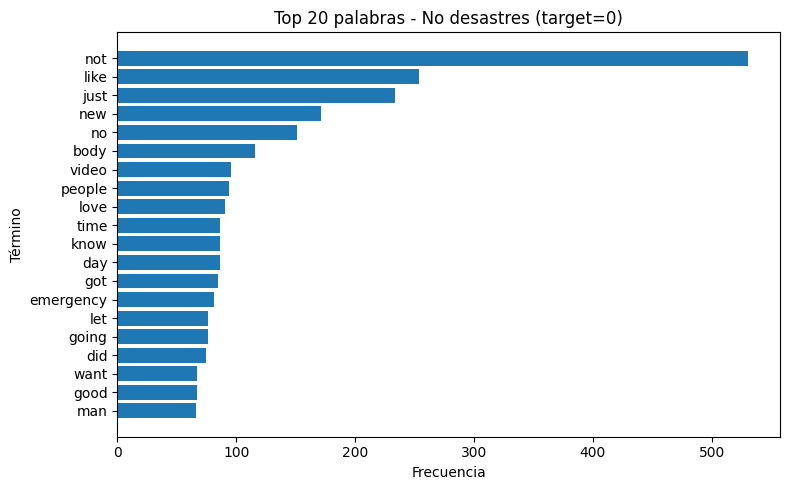

In [103]:
def plot_top_bars(df_freq, title, top_n=20):
    top = df_freq.head(top_n).iloc[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(top["term"], top["freq"])
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("Término")
    plt.tight_layout()
    plt.show()

plot_top_bars(freq_1, "Top 20 palabras - Desastres (target=1)", top_n=20)
plot_top_bars(freq_0, "Top 20 palabras - No desastres (target=0)", top_n=20)

### Palabras en ambas categorías y sus sesgo 

In [104]:
both = (freq_1.rename(columns={"freq":"freq_1"})
             .merge(freq_0.rename(columns={"freq":"freq_0"}), on="term", how="inner"))

both["share_1"] = both["freq_1"] / both["freq_1"].sum()
both["share_0"] = both["freq_0"] / both["freq_0"].sum()
eps = 1e-12
both["log_ratio"] = np.log((both["share_1"] + eps) / (both["share_0"] + eps))
both["abs_diff"] = (both["share_1"] - both["share_0"]).abs()

ambiguous = both.sort_values("abs_diff", ascending=True).head(25)

towards_disaster = both.sort_values("log_ratio", ascending=False).head(25)
towards_nondisaster = both.sort_values("log_ratio", ascending=True).head(25)

print("Palabras presentes en ambas categorías (más 'neutrales'):")
display(ambiguous[["term","freq_1","freq_0","share_1","share_0"]])

print("Presentes en ambas pero más asociadas a DESASTRES (log_ratio alto):")
display(towards_disaster[["term","freq_1","freq_0","log_ratio"]])

print("Presentes en ambas pero más asociadas a NO DESASTRES (log_ratio bajo):")
display(towards_nondisaster[["term","freq_1","freq_0","log_ratio"]])

Palabras presentes en ambas categorías (más 'neutrales'):


,term,freq_1,freq_0,share_1,share_0
332,hijacking,15,17,0.000691,0.000691
194,plan,23,26,0.001059,0.001057
675,ppl,8,9,0.000368,0.000366
666,taking,8,9,0.000368,0.000366
644,london,8,9,0.000368,0.000366
658,moment,8,9,0.000368,0.000366
759,hour,7,8,0.000322,0.000325
755,dr,7,8,0.000322,0.000325
769,problem,7,8,0.000322,0.000325
3664,yahistorical,1,1,0.000046,0.000041


Presentes en ambas pero más asociadas a DESASTRES (log_ratio alto):


,term,freq_1,freq_0,log_ratio
10,hiroshima,94,1,4.667274
21,mh,73,1,4.414438
32,bomber,60,1,4.218324
35,typhoon,58,1,4.184422
50,malaysia,49,1,4.015799
64,spill,43,1,3.885179
71,saudi,40,1,3.812858
70,wreckage,40,1,3.812858
67,outbreak,40,1,3.812858
85,suspect,35,1,3.679327


Presentes en ambas pero más asociadas a NO DESASTRES (log_ratio bajo):


,term,freq_1,freq_0,log_ratio
3275,bags,1,43,-3.637221
3276,bag,1,40,-3.564900
3046,ruin,1,37,-3.486939
3359,ebay,1,29,-3.243317
3517,electrocute,1,28,-3.208226
2436,leather,1,21,-2.920543
3258,ball,1,20,-2.871753
2523,mayhem,1,19,-2.820460
2851,cake,1,18,-2.766393
3634,womens,1,17,-2.709234


<small>

### Palabras presentes en ambas 

**Neutrales (presentes en ambas):** la tabla muestra términos con participación casi idéntica en ambas clases (shares muy similares), como hijacking, plan, ppl, taking, london, moment, hour, dr, problem e incluso un largo “cola” de palabras de frecuencia 1. Aunque algunos suenen “serios” (hijacking), no discriminan por sí solos en este corpus: aparecen tanto en noticias reales como en conversación general. Por lo que conviene tratarlos como neutros y apoyarse en n-gramas para aportar contexto (p. ej., plane hijacking vs. usos figurativos), manteniéndolos en el modelo pero sin darles peso interpretativo en visualizaciones.

**Más asociadas a cada clase:** en desastres (1) destacan términos casi exclusivos (log_ratio alto) que anclan evento + lugar/impacto: hiroshima, mh, bomber/bombing, typhoon, malaysia, spill, outbreak, wreckage, airport/aircraft, declares, severe, migrants. Son excelentes señales para el clasificador y justifican usar n-gramas como northern california wildfire. En no desastres (0) dominan palabras de consumo/ocio y estilo de vida (bags/bag, ebay, fashion, buy, song, awesome), además de coloquiales (blew, panicking) que suelen ser figurativas; su fuerte sesgo negativo ayuda a reducir falsos positivos. En conjunto, estas listas orientan la ingeniería de características: priorizar términos con alto sesgo hacia su clase, usar (bi/tri)gramas para contexto y filtrar artefactos en visualizaciones.

</small>

### Modelo de Regresión Logística 

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

In [106]:
X_raw = df["text"].fillna("")
y = df["target"].astype(int).values

In [107]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=42, stratify=y
)

In [108]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        return [clean_text(t) for t in X]

In [109]:
pipeline = Pipeline(steps=[
    ("clean", TextCleaner()),
    ("vect", CountVectorizer(
        ngram_range=(1,2),   
        min_df=2,            
        max_features=50000   
    )),
    ("clf", LogisticRegression(
        solver="liblinear", 
        class_weight="balanced",  
        max_iter=1000,
        random_state=42
    ))
])

In [110]:
pipeline.fit(X_train_raw, y_train)

,steps,"[('clean', ...), ('vect', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [111]:
y_pred = pipeline.predict(X_test_raw)
y_proba = pipeline.predict_proba(X_test_raw)[:,1]

print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred, digits=3))

Reporte de Clasificación:

              precision    recall  f1-score   support

           0      0.799     0.825     0.812      1303
           1      0.757     0.725     0.741       981

    accuracy                          0.782      2284
   macro avg      0.778     0.775     0.776      2284
weighted avg      0.781     0.782     0.781      2284



In [112]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print("Matriz de confusión:\n", cm)
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC:  {auc:.3f}")

Matriz de confusión:
 [[1075  228]
 [ 270  711]]
Accuracy: 0.782
ROC-AUC:  0.845


In [113]:
LABELS = {1: "Indica desastre ⚠️❗", 0: "No indica desastre 🙂"}

In [114]:
def predict_tweet(text, threshold=0.5, return_details=True):
    """
    Clasifica un tweet como Desastre (1) o No desastre (0).
    - threshold: umbral sobre la probabilidad de clase positiva.
    - return_details: si True, devuelve texto amigable con probabilidad y etiqueta.
    """
    proba = pipeline.predict_proba([text])[0, 1]
    pred = 1 if proba >= threshold else 0
    if return_details:
        return f"{LABELS[pred]}  (p={proba:.3f}, umbral={threshold})"
    return pred, proba

In [115]:
ejemplos = [
    "Breaking: Massive earthquake reported in downtown San Francisco.",
    "Had a great time at the beach today, the sunset was beautiful.",
    "Just finished my workout, feeling awesome!",
    "Flash flooding in Texas forces hundreds to evacuate their homes.",
    "My dog loves playing in the park every morning.",
    "Wildfire spreads rapidly near Los Angeles, thousands under evacuation orders.",
    "Watching Netflix all night, any good recommendations?",
    "Train crash leaves several injured, emergency teams on site.",
    "Tornado warning issued for Oklahoma City area. Residents advised to take shelter.",
    "Trying a new pasta recipe for dinner tonight!",
    "Happy birthday to my best friend, wish you all the best!",
    "Category 4 hurricane makes landfall on the east coast.",
    "Explosion in chemical plant causes fire and smoke visible for miles.",
    "Football game tonight was amazing, what a goal!",
    "Major landslide blocks highway, rescue operations underway.",
    "Enjoying my vacation in Paris, such a lovely city.",
    "Bridge collapse reported during rush hour, multiple casualties feared.",
    "Listening to music and relaxing after a long day.",
    "Volcano eruption spews ash cloud over nearby villages.",
    "Can't wait for the weekend party with friends.",
    "No a disaster here, just a lovely day with family!", 
    "Theres no more floading in my area, everything is fine now."
    
]
for t in ejemplos:
    print("Texto:", t)
    print("Resultado:", predict_tweet(t))
    print()

Texto: Breaking: Massive earthquake reported in downtown San Francisco.
Resultado: Indica desastre ⚠️❗  (p=0.962, umbral=0.5)

Texto: Had a great time at the beach today, the sunset was beautiful.
Resultado: No indica desastre 🙂  (p=0.196, umbral=0.5)

Texto: Just finished my workout, feeling awesome!
Resultado: No indica desastre 🙂  (p=0.072, umbral=0.5)

Texto: Flash flooding in Texas forces hundreds to evacuate their homes.
Resultado: Indica desastre ⚠️❗  (p=0.993, umbral=0.5)

Texto: My dog loves playing in the park every morning.
Resultado: No indica desastre 🙂  (p=0.194, umbral=0.5)

Texto: Wildfire spreads rapidly near Los Angeles, thousands under evacuation orders.
Resultado: Indica desastre ⚠️❗  (p=0.946, umbral=0.5)

Texto: Watching Netflix all night, any good recommendations?
Resultado: No indica desastre 🙂  (p=0.110, umbral=0.5)

Texto: Train crash leaves several injured, emergency teams on site.
Resultado: Indica desastre ⚠️❗  (p=0.887, umbral=0.5)

Texto: Tornado warning 

<small>

### Resultados del modelo 

El modelo de Regresión Logística con n-gramas (1–2) obtiene un desempeño estable: accuracy=0.782 y ROC-AUC=0.845 en 2,284 ejemplos, con mejor balance en no-desastres (0) (precision=0.799, recall=0.825, F1=0.812) que en desastres (1) (precision=0.757, recall=0.725, F1=0.741). La matriz de confusión muestra TN=1075, FP=228, FN=270, TP=711, es decir, identifica la mayoría de tuits de desastre pero aún pierde algunos y genera ciertos falsos positivos. Los ejemplos de prueba son coherentes: mensajes con léxico inequívoco (earthquake, flash flooding, wildfire, train crash, tornado warning, bridge collapse) reciben probabilidades altas (p≈0.80–0.99), mientras que textos cotidianos (beach, Netflix, birthday, pasta, music) quedan bajos (p<0.20). Los casos cercanos al umbral (p≈0.55–0.68, p. ej. “Explosion in chemical plant…”, “Volcano eruption…”) evidencian que el umbral 0.5 gobierna el trade-off precisión/recall: puede ajustarse según la prioridad operativa (subirlo para menos falsos positivos o bajarlo para captar más desastres).

</small>